#  Q1a

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
df_grad = pd.read_csv('Admission_Predict.csv')
df_grad.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
df_admin_pred = df_grad.copy().drop(columns = ['Serial No.', 'University Rating', 'Chance of Admit '])
df_admin_pred.head()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research
0,337,118,4.5,4.5,9.65,1
1,324,107,4.0,4.5,8.87,1
2,316,104,3.0,3.5,8.00,1
3,322,110,3.5,2.5,8.67,1
4,314,103,2.0,3.0,8.21,0


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_admin_pred.values)
ar_inputs_nml = scaler.transform(df_admin_pred.values)

In [5]:
df_admin_nml = pd.DataFrame(ar_inputs_nml, columns = df_admin_pred.columns)
df_admin_nml.head()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research
0,1.819238,1.778865,1.137360,1.098944,1.776806,0.886405
1,0.667148,-0.031601,0.632315,1.098944,0.485859,0.886405
2,-0.041830,-0.525364,-0.377773,0.017306,-0.954043,0.886405
3,0.489904,0.462163,0.127271,-1.064332,0.154847,0.886405
4,-0.219074,-0.689952,-1.387862,-0.523513,-0.606480,-1.128152


## Q1b

## Reference code for a simple perceptron
reference [Neural Networks and Deep Learning, Ch. 2](http://neuralnetworksanddeeplearning.com/chap2.html)

In [6]:
def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1-np.tanh(x)**2

In [7]:
class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### initialize parameters ###
        self.weights= [np.random.random() * 0.05 for i in range(self.input_dim)]
        self.biases= np.random.random() * 0.05

    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ###
        #print(X.shape, self.weights, self.biases)
        self.z = (np.dot(X, self.weights)) + self.biases              #shape(X.shape[0],1)
        self.a = self.activation(self.z)                              #shape(X.shape[0],1)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        self.predict(X)
        errors=np.squeeze((self.a-y)*self.activation_grad(self.z))
        weights_grad=errors.dot(X) # errors.T.dot(X)
        bias_grad=np.sum(errors,axis=0)
        ### Update weights and biases from the gradient ###
        self.weights -= (2 * self.lr * weights_grad)
        self.biases -= (2 * self.lr * bias_grad)
        #print(self.biases, self.weights)
        #return self.biases

        
    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        #print(X[order[n*batch_size:]].shape, y[order[n*batch_size:]].shape )
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])
        
    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        return np.mean(np.square(self.predict(X) - y))
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.biases=weights[1]

In [8]:
y = df_grad['Chance of Admit '].values
y[:12]

array([0.92, 0.76, 0.72, 0.8 , 0.65, 0.9 , 0.75, 0.68, 0.5 , 0.45, 0.52,
       0.84])

In [9]:
percept = simple_perceptron(6,1, 0.01, tanh, tanh_grad)
percept.fit(df_admin_nml.values[:34], y[:34])

In [10]:
percept = simple_perceptron(6,1, 0.01, tanh, tanh_grad)
vals = percept.train_on_epoch(df_admin_nml.values[:44], y[:44])

## Q1c

In [11]:
from sklearn.model_selection import train_test_split,KFold


def Kfold(k,Xs,ys,epochs,input_dim, learning_rate=0.0001,draw_curve=True):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        test_Xs= Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, test_size= 0.2)
        
        ### Establish the model for simple perceptron here ###
        model= simple_perceptron(input_dim,1,learning_rate, tanh, tanh_grad)
        
        # Save the lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_on_epoch(train_in,train_real)
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        final_epochs= np.where(val_array == np.min(val_array))[0].item()
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error= model.evaluate(train_Xs, train_ys)
        train_error_all.append(train_error)
        test_error= model.evaluate(test_Xs, test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


Number of epochs with lowest validation: 272
Train error: 0.004199752693021209
Test error: 0.004771232396561957
Number of epochs with lowest validation: 334
Train error: 0.004435654961062194
Test error: 0.003692802128375167
Number of epochs with lowest validation: 528
Train error: 0.004128086104100377
Test error: 0.00442558894127907
Number of epochs with lowest validation: 847
Train error: 0.004176595527185613
Test error: 0.004192023982860481
Number of epochs with lowest validation: 702
Train error: 0.0039612766988501675
Test error: 0.0050743677346867
Final results:
Training error:0.004180+-0.000153
Testing error:0.004431+-0.000476


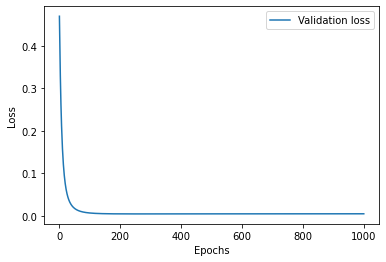

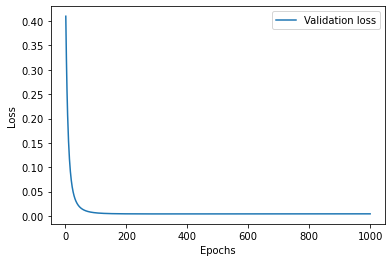

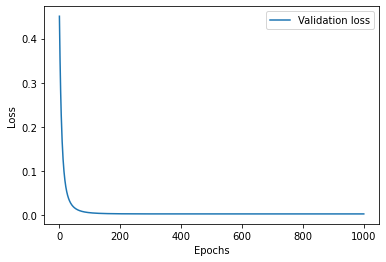

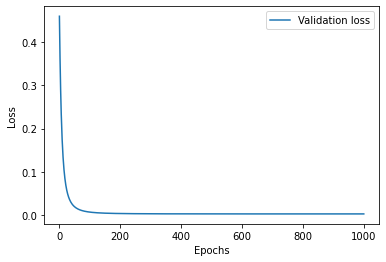

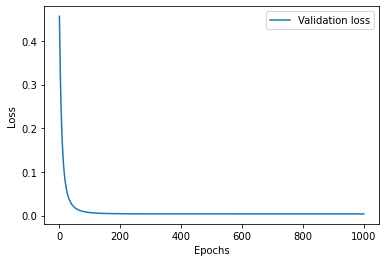

In [12]:
Kfold(5, ar_inputs_nml, y, 1000, 6)

Yes, the features are good indicators for getting into graduate school, evident from the extremely small testing error. 

## Removing the GRE scores feature and Running the Same Test

In [13]:
df_no_gre = df_admin_nml.drop(columns = 'GRE Score')
df_no_gre

,TOEFL Score,SOP,LOR,CGPA,Research
0,1.778865,1.137360,1.098944,1.776806,0.886405
1,-0.031601,0.632315,1.098944,0.485859,0.886405
2,-0.525364,-0.377773,0.017306,-0.954043,0.886405
3,0.462163,0.127271,-1.064332,0.154847,0.886405
4,-0.689952,-1.387862,-0.523513,-0.606480,-1.128152
...,...,...,...,...,...
495,0.132987,1.137360,0.558125,0.734118,0.886405
496,1.614278,1.642404,1.639763,2.140919,0.886405
497,2.108041,1.137360,1.639763,1.627851,0.886405
498,-0.689952,0.632315,1.639763,-0.242367,-1.128152


Number of epochs with lowest validation: 341
Train error: 0.00429792934711457
Test error: 0.004407787907891935
Number of epochs with lowest validation: 343
Train error: 0.004146498798457784
Test error: 0.0050445331494442846
Number of epochs with lowest validation: 426
Train error: 0.003990994220965744
Test error: 0.005642942368305129
Number of epochs with lowest validation: 343
Train error: 0.0045619009376249055
Test error: 0.003948405390143791
Number of epochs with lowest validation: 999
Train error: 0.004615914858025324
Test error: 0.0032780359830025417
Final results:
Training error:0.004323+-0.000239
Testing error:0.004464+-0.000825


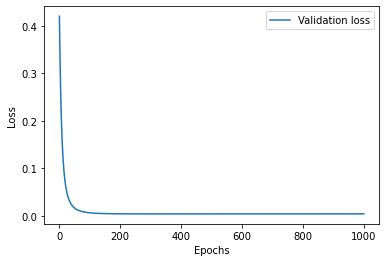

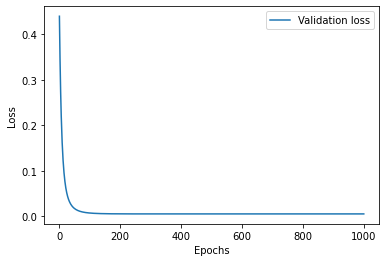

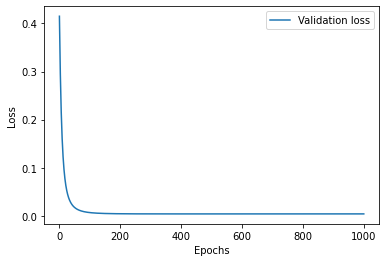

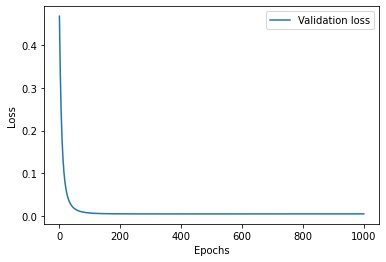

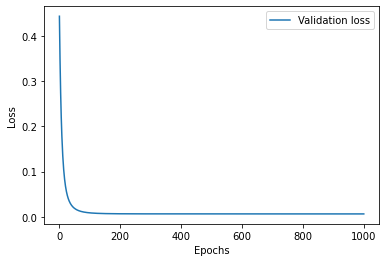

In [14]:
# Using just 5 features since removing GRE feature
Kfold(5, df_no_gre.values, y, 1000, 5)

I am still getting the same amount of test error regardless if the feature dataset contains GRE scores or not, so don't think GRE scores are an important indicator for whether you get into grad school or not.  

## Q2a:

In [15]:
df_titanic = pd.read_csv('titantic.csv')
print(df_titanic.shape)
df_titanic.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df_titan_filtered = df_titanic.dropna()
df_titan_filtered.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [17]:
df_titanic['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [18]:
df_titan_feats = df_titan_filtered.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
df_titan_feats.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,female,38.0,1,0,71.2833,C
3,1,female,35.0,1,0,53.1000,S
6,1,male,54.0,0,0,51.8625,S
10,3,female,4.0,1,1,16.7000,S
11,1,female,58.0,0,0,26.5500,S


In [19]:
y_surv = df_titan_filtered['Survived'].values
y_surv[:10]

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0])

In [39]:
df_titan_cat = df_titan_feats[['Pclass', 'Sex', 'Embarked']]
df_titan_cat.head()

,Pclass,Sex,Embarked
1,1,female,C
3,1,female,S
6,1,male,S
10,3,female,S
11,1,female,S


In [21]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(df_titan_cat)
ar_onehot_cats = encoder.transform(df_titan_cat).toarray()
ar_onehot_cats

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [22]:
encoder.categories_

[array([1, 2, 3]),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object)]

In [23]:
cat_col_names = ['Pclass_' + str(i) for i in encoder.categories_[0]] + encoder.categories_[1].tolist() + encoder.categories_[2].tolist()
cat_col_names

['Pclass_1', 'Pclass_2', 'Pclass_3', 'female', 'male', 'C', 'Q', 'S']

In [24]:
df_onehot = pd.DataFrame(ar_onehot_cats, columns = cat_col_names)
df_onehot.head()

,Pclass_1,Pclass_2,Pclass_3,female,male,C,Q,S
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [25]:
# Normalizing continuous features
scaler.fit(df_titan_feats.drop(columns = ['Pclass', 'Sex', 'Embarked']).values)
ar_titans_nml = scaler.transform(df_titan_feats.drop(columns = ['Pclass', 'Sex', 'Embarked']).values)
ar_titans_nml[:10]

array([[ 0.14906507,  0.83362754, -0.63172982, -0.0971798 ],
       [-0.0432295 ,  0.83362754, -0.63172982, -0.3359971 ],
       [ 1.17463611, -0.7230443 , -0.63172982, -0.35225028],
       [-2.03027338,  0.83362754,  0.69708118, -0.81407038],
       [ 1.43102886, -0.7230443 , -0.63172982, -0.68470165],
       [-0.10732769, -0.7230443 , -0.63172982, -0.86266574],
       [-0.49191683, -0.7230443 , -0.63172982, -0.56715341],
       [-1.06880054,  3.94697121,  2.02589219,  2.42080454],
       [ 0.85414516,  0.83362754, -0.63172982, -0.025654  ],
       [ 1.87971619, -0.7230443 ,  0.69708118, -0.21937875]])

In [26]:
ar_titans_nml.shape

(183, 4)

In [27]:
#Stack the 2 arrays and got array of all feats 
ar_feats = np.hstack((ar_titans_nml, ar_onehot_cats))
ar_feats.shape

(183, 12)

The difference between question 1 is that there are more categorical variables in this titanic compared to grad admissions dataset, so have to one-hot encode those before using them as features for the model.

## Q2b:

Number of epochs with lowest validation: 999
Train error: 0.1508845729501366
Test error: 0.21710558954403603
Number of epochs with lowest validation: 999
Train error: 0.12149110001236972
Test error: 0.2549363610566511
Number of epochs with lowest validation: 486
Train error: 0.14453589598752203
Test error: 0.17841456580375975
Number of epochs with lowest validation: 999
Train error: 0.154475557915547
Test error: 0.14317956385474695
Number of epochs with lowest validation: 120
Train error: 0.15813873026231973
Test error: 0.177754420059564
Final results:
Training error:0.145905+-0.013006
Testing error:0.194278+-0.038305


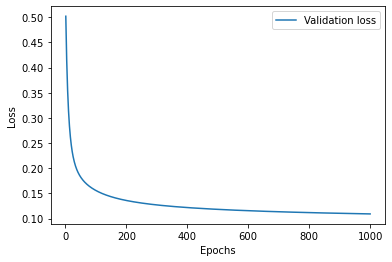

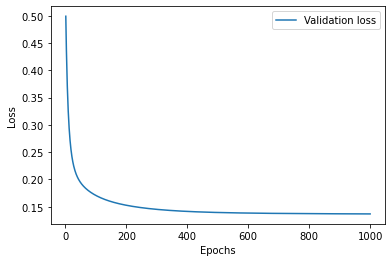

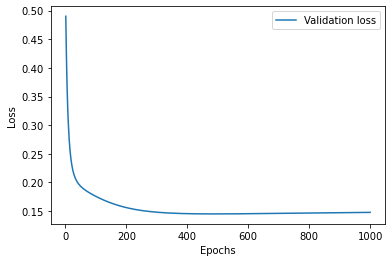

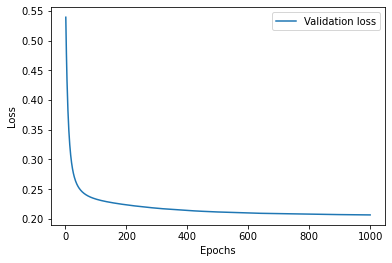

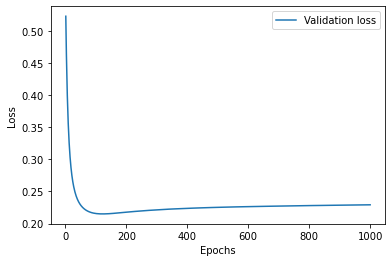

In [28]:
mod_titanic = Kfold(5, ar_feats, y_surv, 1000, 12)

### Predicting who will survive

In [29]:
# Test Loss is around 0.15, and essentially outputting survival probabilities (since output is between 0 to 1) 
# If survival probability is greater than 0.5, assuming the model is predicting it as survived 
df_pred_surv = df_titan_filtered[mod_titanic.predict(ar_feats) > 0.5]
df_pred_surv.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S


In [30]:
df_pred_surv['Survived'].value_counts()

1    97
0    15
Name: Survived, dtype: int64

In [31]:
# Yea, we can predict who will survive and around 83% of the true survivors are predicted accurately
df_pred_surv['Survived'].value_counts()[1] / sum(df_pred_surv['Survived'].value_counts())

0.8660714285714286

Yea, we can predict who will survive and around 80% of the true survivors are predicted accurately

### Removing Ticket Fare and seeing if this helps predict who will get back to shore

In [32]:
encoder = OneHotEncoder()
encoder.fit(df_titan_cat)
ar_onehot_cats = encoder.transform(df_titan_cat).toarray()
ar_onehot_cats

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [33]:
# Normalizing continuous features 
scaler.fit(df_titan_feats.drop(columns = ['Pclass', 'Sex', 'Embarked', 'Age']).values)
ar_titans_nml = scaler.transform(df_titan_feats.drop(columns = ['Pclass', 'Sex', 'Embarked', 'Age']).values)
ar_titans_nml[:10]

array([[ 0.83362754, -0.63172982, -0.0971798 ],
       [ 0.83362754, -0.63172982, -0.3359971 ],
       [-0.7230443 , -0.63172982, -0.35225028],
       [ 0.83362754,  0.69708118, -0.81407038],
       [-0.7230443 , -0.63172982, -0.68470165],
       [-0.7230443 , -0.63172982, -0.86266574],
       [-0.7230443 , -0.63172982, -0.56715341],
       [ 3.94697121,  2.02589219,  2.42080454],
       [ 0.83362754, -0.63172982, -0.025654  ],
       [-0.7230443 ,  0.69708118, -0.21937875]])

In [34]:
#Stack the 2 arrays and got array of all feats 
ar_feats = np.hstack((ar_titans_nml, ar_onehot_cats))
ar_feats.shape

(183, 11)

Number of epochs with lowest validation: 999
Train error: 0.1491434699169984
Test error: 0.1814093470128925
Number of epochs with lowest validation: 999
Train error: 0.1614040607718332
Test error: 0.1516304706038662
Number of epochs with lowest validation: 197
Train error: 0.1644713331014799
Test error: 0.18863204819357238
Number of epochs with lowest validation: 435
Train error: 0.15719898206239247
Test error: 0.15875089543926196
Number of epochs with lowest validation: 165
Train error: 0.1755846345457859
Test error: 0.17213781020015403
Final results:
Training error:0.161560+-0.008699
Testing error:0.170512+-0.013745


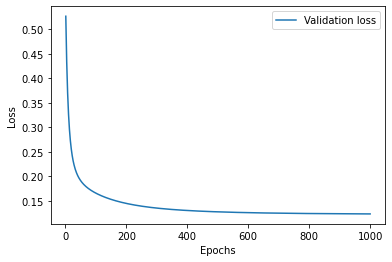

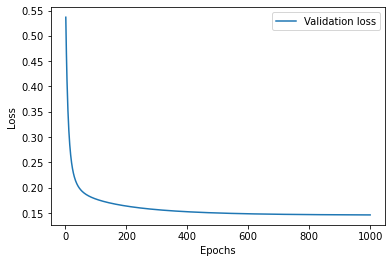

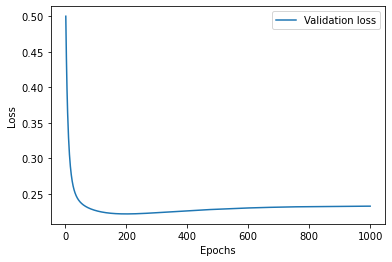

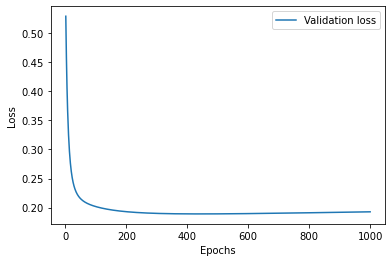

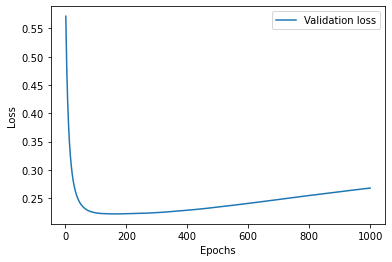

In [35]:
mod_titanic = Kfold(5, ar_feats, y_surv, 1000, 11)

In [36]:
df_pred_surv = df_titan_filtered[mod_titanic.predict(ar_feats) > 0.5]
df_pred_surv.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S


In [37]:
# Yea, we can predict who will survive and around 83% of the true survivors are predicted accurately
df_pred_surv['Survived'].value_counts()[1] / sum(df_pred_surv['Survived'].value_counts())

0.9120879120879121

With the test & train errors around the same, the model without does appear to get a higher percentage of predicted survivors from the true survivor pool. Thus, age is potentially not an important predictor in predicting who will survive the titanic.

## Q3a

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)-5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

This is your training data:

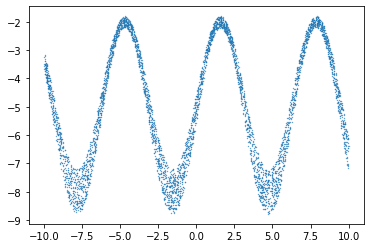

In [41]:
x,y=generate_data(5000,0.1)
plt.scatter(x,y,s=0.1)
x = x.reshape((-1,1))

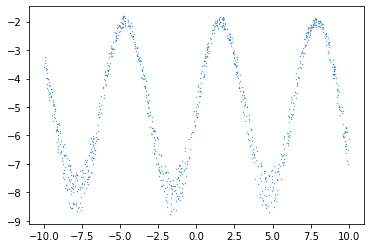

In [42]:
x_test, y_test = generate_data(1000, 0.1)
plt.scatter(x_test, y_test, s = 0.1)

Number of epochs with lowest validation: 999
Train error: 20.609167659036746
Test error: 20.224487404211928
Number of epochs with lowest validation: 999
Train error: 20.560954907424584
Test error: 20.417355516499185
Number of epochs with lowest validation: 999
Train error: 20.40467712689192
Test error: 21.042434082367333
Number of epochs with lowest validation: 999
Train error: 20.452341493582136
Test error: 20.85179976189589
Number of epochs with lowest validation: 999
Train error: 20.63402056279368
Test error: 20.1250866845899
Final results:
Training error:20.532232+-0.089171
Testing error:20.532233+-0.356679


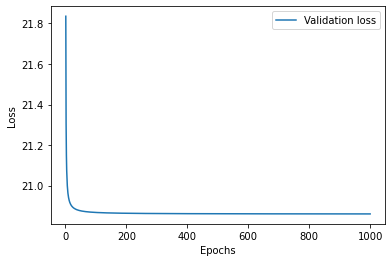

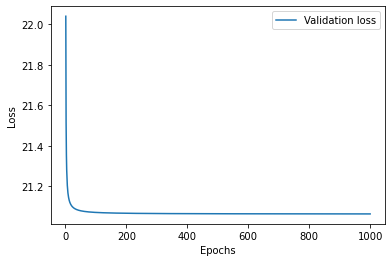

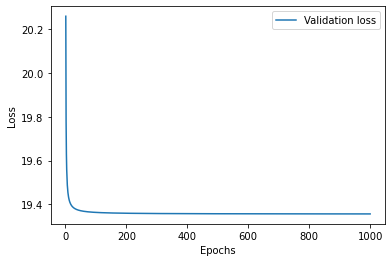

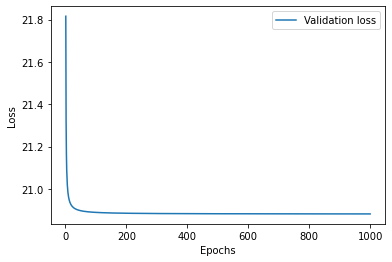

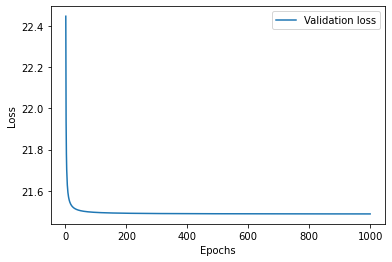

In [43]:
sin_model = Kfold(5,x,y,1000,1)

In [44]:
x_test, y_test = generate_data(1000, stochascity= 0.1)
x_test = x_test.reshape((-1,1))
y_preds_test = sin_model.predict(x_test)

In [45]:
def show_correlation(xs,ys):
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)

Correlation coefficient: 0.24706036204900064


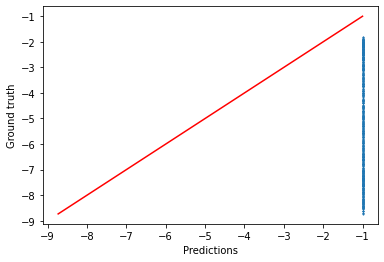

In [46]:
show_correlation(y_preds_test, y_test)

The model's predictions are bad evident from the high test error of 20 and is highlighted even more by the correlation plot revealing that the predictions and ground truth do not match across the entire ground truth range. The low correlation coefficient of 0.21 also supports this critique. 

## (b)

Here we use the Multi-layer Perceptron regressor built-in from sklearn as a simple ANN <br>
[MLP regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [47]:
from sklearn.neural_network import MLPRegressor

def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001,):
    # The total number of examples for training the network
    total_num=len(Xs)

    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_error_all=[]
    test_error_all=[]
    for train_selector,test_selector in kf.split(range(total_num)):
        # Decide training examples and testing examples for this fold
        train_Xs=Xs[train_selector]
        test_Xs= Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        
        # Establish the model here
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hidden_layers).fit(train_Xs, train_ys)
        
        ### Report result for this fold ##
        train_error= np.mean(np.square(model.predict(train_Xs) - train_ys))
        train_error_all.append(train_error)
        test_error= np.mean(np.square(model.predict(test_Xs) - test_ys))
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)

    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


In [48]:
sin_MLP_model = KFold_NN(5,x,y,hidden_layers= 8,epochs=1000,lr=0.001)

/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 1.924466466947544
Test error: 1.8911684436198175


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.6330053963898876
Test error: 0.6045216991227484


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.6415827327884617
Test error: 0.6157355709066726


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.7510948217697667
Test error: 0.7753561773479435
Train error: 0.6104208193324298
Test error: 0.6250550523826598
Final results:
Training error:0.912114+-0.508506
Testing error:0.902367+-0.498323


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
y_pred_MLP = sin_MLP_model.predict(x_test.reshape(-1,1))

Correlation coefficient: 0.9246898208686083


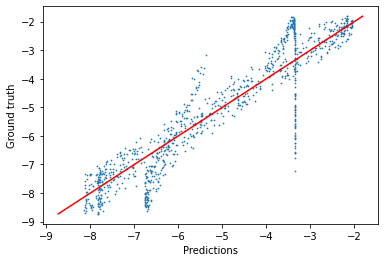

In [50]:
show_correlation(y_pred_MLP, y_test)

Yes, with the addition of one hidden layer, this model's performance is much better than the simple perceptron, which does not have this hidden layer. This is highlighted by the much higher correlation coefficient between this model's predictions and the ground truth. Also, visually, this model is now outputting predictions across the dynamic range of the ground truth, which did not happen when using the simple perceptron. 

## 3c

In [51]:
sin_MLP_model_2lays = KFold_NN(5,x,y,hidden_layers= [8,8],epochs=1000,lr=0.001)

Train error: 0.10880824121016694
Test error: 0.11784665908211564
Train error: 0.11036508558530854
Test error: 0.11443487574807025
Train error: 0.11475186961196616
Test error: 0.11513714285566215
Train error: 0.11267822595218549
Test error: 0.10841970965767493
Train error: 0.10730824266214475
Test error: 0.1021964850998562
Final results:
Training error:0.110782+-0.002664
Testing error:0.111607+-0.005623


In [52]:
x_test, y_test = generate_data(1000, stochascity= 0.1)

In [53]:
y_pred_MLP = sin_MLP_model_2lays.predict(x_test.reshape(-1,1))

Correlation coefficient: 0.9882016792376297


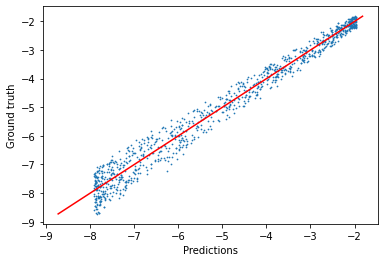

In [54]:
show_correlation(y_pred_MLP, y_test)

By adding one more hidden layer, this model with 2 hidden layers performs much better than the previous model that had just one hidden layer. This is evident from the correlation coefficient being much higher (0.987 vs 0.924) and visually, this model's predictions are closely matching the ground truth with slight over and under predictions for most of the points. Thus, you can improve performance by adding more hidden layers. 